In [1]:
# Import Libraries
import json
import numpy as np
import random
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import f1_score

In [2]:
# Create Data Classes
class Category:
    ELECTRONICS = "ELECTRONICS"
    BOOKS = "BOOKS"
    CLOTHING = "CLOTHING"
    GROCERY = "GROCERY"
    PATIO = "PATIO"
    
class Sentiment:
    POSITIVE = "POSITIVE"
    NEGATIVE = "NEGATIVE"
    NEUTRAL = "NEUTRAL"

class Review:
    def __init__(self, category, text, score):
        self.category = category
        self.text = text
        self.score = score
        self.sentiment = self.get_sentiment()
        
    def get_sentiment(self):
        if self.score <= 2:
            return Sentiment.NEGATIVE
        elif self.score == 3:
            return Sentiment.NEUTRAL
        else: # Amazon review is a 4 or 5
            return Sentiment.POSITIVE
        
class ReviewContainer:
    def __init__(self, reviews):
        self.reviews = reviews
    
    def get_text(self):
        return [x.text for x in self.reviews]
    
    def get_x(self, vectorizer):
        return vectorizer.transform(self.get_text())
    
    def get_y(self):
        return [x.sentiment for x in self.reviews]
    
    def get_category(self):
        return [x.category for x in self.reviews]
    
    def evenly_distribute(self):
        negative = list(filter(lambda x: x.sentiment == Sentiment.NEGATIVE, self.reviews))
        positive = list(filter(lambda x: x.sentiment == Sentiment.POSITIVE, self.reviews))
        positive_shrunk = positive[:len(negative)]
        print(len(positive_shrunk))
        self.reviews = negative + positive_shrunk
        random.shuffle(self.reviews)
        print(self.reviews[0])

In [3]:
# Load in the Data
file_names = ['./data/category/Electronics_small.json', './data/category/Books_small.json', './data/category/Clothing_small.json', './data/category/Grocery_small.json', './data/category/Patio_small.json']
file_categories = [Category.ELECTRONICS, Category.BOOKS, Category.CLOTHING, Category.GROCERY, Category.PATIO]

reviews = []
for i in range(len(file_names)):
    file_name = file_names[i]
    category = file_categories[i]
    with open(file_name) as f:
        for line in f:
            review_json = json.loads(line)
            review = Review(category, review_json['reviewText'], review_json['overall'])
            reviews.append(review)

In [4]:
# Data Prep
train, test = train_test_split(reviews, test_size = 0.33, random_state=42)

train_container = ReviewContainer(train)
#train_container.evenly_distribute()
test_container = ReviewContainer(test)
#test_container.evenly_distribute()

corpus = train_container.get_text()
# vectorizer = CountVectorizer(binary=True)
# vectorizer.fit(corpus)
vectorizer = TfidfVectorizer()
vectorizer.fit(corpus)

train_x = train_container.get_x(vectorizer)
train_y = train_container.get_category()

test_x = test_container.get_x(vectorizer)
test_y = test_container.get_category()

In [5]:
# Classification
# Support Vector Classifier from sklearn import svm

clf = svm.SVC(C=16, kernel='linear', gamma='auto')
clf.fit(train_x, train_y)

SVC(C=16, gamma='auto', kernel='linear')

In [6]:
test_set = ['great for my wedding', "loved it in my garden", 'good computer']
new_test = vectorizer.transform(test_set)

clf.predict(new_test)

array(['CLOTHING', 'PATIO', 'ELECTRONICS'], dtype='<U11')

In [7]:
# Classification
# Naive Bayes Classifier
# Naive Bayes Classifier
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()

# print(train_x)
gnb.fit(train_x.todense(),train_y)
gnb.score(test_x.todense(),test_y)

C:\python39\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\python39\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


0.8109090909090909

In [8]:
# Performance
y_pred = clf.predict(test_x)

f1_score(test_y, y_pred, average=None)

# for i in range(len(y_pred)):
#     print(y_pred[i], test_y[i])

array([0.95111111, 0.89323308, 0.88567294, 0.89891135, 0.91693291])

In [9]:
# Classifier Score
clf.score(test_x, test_y)

0.9090909090909091

In [10]:
# Tuning with GridSearch
from sklearn.model_selection import GridSearchCV

parameters = {'kernel':('linear', 'rbf'), 'C':[0.1,1,8,16,32]}
svc = svm.SVC()
clf = GridSearchCV(svc, parameters, cv=5)
clf.fit(train_x, train_y)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.1, 1, 8, 16, 32], 'kernel': ('linear', 'rbf')})

In [11]:
# Classifier Score after GridSearch tuning
clf.score(test_x, test_y)

0.9187878787878788

In [12]:
# Save the Model
import pickle

with open('./models/category_classifier_EP.pkl', 'wb') as f:
    pickle.dump(clf, f)
    
with open('./models/category_vectorizer_EP.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)

In [13]:
# Load the Model
import pickle

with open('./models/category_classifier_EP.pkl', 'wb') as f:
    pickle.dump(clf, f)
    
with open('./models/category_vectorizer_EP.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)

In [15]:
# Testing the model after loading it
test_set = ['very slow speeds', "loved the shirt", 'good']
new_test = vectorizer.transform(test_set)

clf.predict(new_test)

array(['ELECTRONICS', 'CLOTHING', 'GROCERY'], dtype='<U11')

<AxesSubplot:>

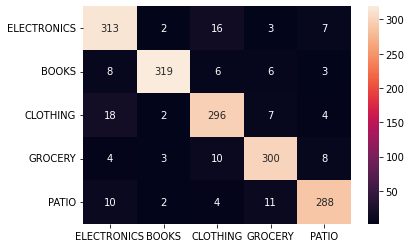

In [16]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib as plt

y_pred = clf.predict(test_x)

labels = [Category.ELECTRONICS, Category.BOOKS, Category.CLOTHING, Category.GROCERY, Category.PATIO]

cm = confusion_matrix(test_y, y_pred, labels=labels)
df_cm = pd.DataFrame(cm, index=labels, columns=labels)

sn.heatmap(df_cm, annot=True, fmt='d')